In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
import torch
from sklearn.model_selection import train_test_split

import os
import sys

from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
from transformers import HubertModel, HubertConfig, Wav2Vec2Processor
import torch.nn as nn
import torch


d:\python\envs\labplnta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = np.load('./data_severity.npy', allow_pickle=True)
labels = np.load('./labels_severity.npy', allow_pickle=True)

print(data.shape)
print(labels.shape)

(4033, 112000)
(4033,)


In [3]:
model_name_or_path = "facebook/hubert-base-ls960"

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path,)
target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [4]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=33, stratify=labels)

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=5)
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=5)

(3226, 112000) (3226,)
(807, 112000) (807,)


In [6]:
print(y_train.shape, y_test.shape)

torch.Size([3226, 5]) torch.Size([807, 5])


In [7]:
#create a list of arrays for the training data
train_data = []
for i in range(len(x_train)):
    train_data.append(x_train[i])
    
#create a list of arrays for the testing data
test_data = []
for i in range(len(x_test)):
    test_data.append(x_test[i])
    
print(train_data[0])
print(test_data[0])

print(len(train_data), len(test_data))

[-0.00234985 -0.00268555 -0.00134277 ... -0.00878906 -0.00805664
 -0.00747681]
[ 1.2207031e-04  1.2207031e-04  6.1035156e-05 ... -2.9602051e-03
 -3.4484863e-03 -4.0588379e-03]
3226 807


In [8]:
features_train = feature_extractor(train_data, sampling_rate=target_sampling_rate)
features_test = feature_extractor(test_data, sampling_rate=target_sampling_rate)

print(features_train.keys())
print(features_test.keys())
print(features_train['input_values'][0])

dict_keys(['input_values'])
dict_keys(['input_values'])
[-0.12088266 -0.13840723 -0.06830896 ... -0.4570358  -0.41880038
 -0.38853067]


In [9]:
features_train['labels'] = [label for label in y_train]
features_test['labels'] = [label for label in y_test]

print(features_train['labels'][:50])

[tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 1, 0, 0, 0]), tensor([0, 0, 0, 1, 0]), tensor([0, 0, 0, 1, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 0, 0, 1, 0]), tensor([0, 1, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 0, 0, 1, 0]), tensor([0, 1, 0, 0, 0]), tensor([0, 1, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 1, 0, 0, 0]), tensor([0, 0, 1, 0, 0]), tensor([0, 0, 0, 1, 0]), tensor([0, 0, 0, 1, 0]), tensor([0, 1, 0, 0, 0]), tensor([0, 1, 0, 0, 0]), tensor([0, 1, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 0, 1, 0, 0]), tensor([0, 1, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 0, 1, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 0, 0, 1, 0]), tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 0, 1, 0, 0]), tensor([0, 0, 1, 0, 0]), tensor([0, 1, 0, 0, 0]), tensor([1, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 1]), tensor([1, 0, 0, 0, 0]),

In [10]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        input_values = torch.tensor(self.encodings['input_values'][idx], dtype=torch.float)
        labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly
        return {'input_values': input_values, 'labels': labels}

    def __len__(self):
        return len(self.encodings['input_values'])

    
train_dataset = Dataset(features_train)
test_dataset = Dataset(features_test)

print(train_dataset[9])
print(test_dataset[9])

{'input_values': tensor([-2.5145, -2.6991, -2.9758,  ..., -1.0219, -0.8769, -0.7451]), 'labels': tensor([[1., 0., 0., 0., 0.]])}
{'input_values': tensor([-0.1155, -0.0957, -0.2171,  ...,  0.4292,  0.2699,  0.0196]), 'labels': tensor([[1., 0., 0., 0., 0.]])}


C:\Users\ramona\AppData\Local\Temp\ipykernel_20288\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

print(len(train_loader), len(test_loader))

3226 807


In [12]:
print(f"Training input_values: {train_dataset[0]['input_values']}")
print(f"Training labels: {train_dataset[0]['labels']}")

Training input_values: tensor([-0.1209, -0.1384, -0.0683,  ..., -0.4570, -0.4188, -0.3885])
Training labels: tensor([[1., 0., 0., 0., 0.]])


C:\Users\ramona\AppData\Local\Temp\ipykernel_20288\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


In [13]:
# Define the model class
class HubertForMulticlassClassification(nn.Module):
    def __init__(self, hubert_model_name='facebook/hubert-base-ls960', num_classes=5):
        super(HubertForMulticlassClassification, self).__init__()
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(hubert_model_name)
        self.hubert = HubertModel.from_pretrained(hubert_model_name)
        self.classifier = nn.Linear(self.hubert.config.hidden_size, num_classes)
    
    def forward(self, input_values):
        outputs = self.hubert(input_values).last_hidden_state
        # Use the mean of the last hidden state as the input to the classifier
        mean_output = torch.mean(outputs, dim=1)
        logits = self.classifier(mean_output)
        return logits


In [14]:
# Instantiate the model
model = HubertForMulticlassClassification(num_classes=5)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model.to(device)

d:\python\envs\labplnta\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

HubertForMulticlassClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (enc

In [15]:
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter('runs/hubert_depression_multiclass_experiment_4_cata')

In [16]:
def train(model, train_loader, optimizer, criterion, device, writer, epoch):
    
    
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        
        # print(input_values.shape)
        # print(labels.shape)
        
        labels = labels.squeeze(1)
        
        optimizer.zero_grad()
        outputs = model(input_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # break
        
        total_loss += loss.item()

        # Log training loss
        if batch_idx % 10 == 0:  # Log every 10 batches
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + batch_idx)

    avg_loss = total_loss / len(train_loader)
    return avg_loss


def evaluate(model, test_loader, criterion, device, writer, epoch):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)
            
            labels = labels.squeeze(1)
            
           
            labels = torch.argmax(labels, axis=1)
            # print("LABEL: ", labels)
            outputs = model(input_values)
            # print("OUTPUT: ", outputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            # print("PREDICTION: ", torch.argmax(outputs, axis=1).cpu().numpy())

    avg_loss = total_loss / len(test_loader)

    # Calculate additional metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Log validation metrics
    writer.add_scalar('Validation Loss', avg_loss, epoch)
    writer.add_scalar('Validation Accuracy', accuracy, epoch)
    writer.add_scalar('Validation Precision', precision, epoch)
    writer.add_scalar('Validation Recall', recall, epoch)
    writer.add_scalar('Validation F1 Score', f1, epoch)

    return avg_loss, accuracy, precision, recall, f1

def save_model(model, optimizer, epoch, model_path):
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_save_path = os.path.join(model_path, f'model_epoch_{epoch}.pth')
    optimizer_save_path = os.path.join(model_path, f'optimizer_epoch_{epoch}.pth')
    torch.save(model.state_dict(), model_save_path)
    torch.save(optimizer.state_dict(), optimizer_save_path)
    print(f"Model and optimizer saved to {model_save_path} and {optimizer_save_path}")

def load_model(model_path, epoch):
    model = HubertForMulticlassClassification()
    model_load_path = os.path.join(model_path, f'model_epoch_{epoch}.pth')
    optimizer_load_path = os.path.join(model_path, f'optimizer_epoch_{epoch}.pth')
    model.load_state_dict(torch.load(model_load_path))
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    optimizer.load_state_dict(torch.load(optimizer_load_path))
    
    model.to(device)
    return model, optimizer

In [17]:
# Training and evaluation setup
num_epochs = 10
model_path = './hubert_depression_multiclass_model'

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, writer, epoch)
    val_loss, accuracy, precision, recall, f1 = evaluate(model, test_loader, criterion, device, writer, epoch)
    # break
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    
    # Save the model after each epoch
    save_model(model, optimizer, epoch, model_path)

# Close the writer
writer.close()

C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly
d:\python\envs\labplnta\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
Train Loss: 0.7331
Validation Loss: 0.1081
Accuracy: 0.9628, Precision: 0.9426, Recall: 0.9628, F1 Score: 0.9521
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_0.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_0.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 2/10
Train Loss: 0.2178
Validation Loss: 0.0639
Accuracy: 0.9777, Precision: 0.9781, Recall: 0.9777, F1 Score: 0.9754
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_1.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_1.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 3/10
Train Loss: 0.1607
Validation Loss: 0.0355
Accuracy: 0.9938, Precision: 0.9938, Recall: 0.9938, F1 Score: 0.9938
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_2.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_2.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 4/10
Train Loss: 0.1020
Validation Loss: 0.0408
Accuracy: 0.9888, Precision: 0.9889, Recall: 0.9888, F1 Score: 0.9888
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_3.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_3.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 5/10
Train Loss: 0.1000
Validation Loss: 0.0414
Accuracy: 0.9888, Precision: 0.9890, Recall: 0.9888, F1 Score: 0.9888
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_4.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_4.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 6/10
Train Loss: 0.0728
Validation Loss: 0.1254
Accuracy: 0.9715, Precision: 0.9731, Recall: 0.9715, F1 Score: 0.9717
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_5.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_5.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 7/10
Train Loss: 0.0928
Validation Loss: 0.0374
Accuracy: 0.9901, Precision: 0.9902, Recall: 0.9901, F1 Score: 0.9901
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_6.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_6.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 8/10
Train Loss: 0.0751
Validation Loss: 0.0506
Accuracy: 0.9827, Precision: 0.9828, Recall: 0.9827, F1 Score: 0.9817
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_7.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_7.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 9/10
Train Loss: 0.0428
Validation Loss: 0.1342
Accuracy: 0.9665, Precision: 0.9692, Recall: 0.9665, F1 Score: 0.9666
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_8.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_8.pth


C:\Users\ramona\AppData\Local\Temp\ipykernel_7336\3042093823.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(self.encodings['labels'][idx], dtype=torch.float).unsqueeze(0)  # Ensure labels are shaped correctly


Epoch 10/10
Train Loss: 0.0486
Validation Loss: 0.0585
Accuracy: 0.9777, Precision: 0.9780, Recall: 0.9777, F1 Score: 0.9748
Model and optimizer saved to ./hubert_depression_multiclass_model_cata\model_epoch_9.pth and ./hubert_depression_multiclass_model_cata\optimizer_epoch_9.pth


Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

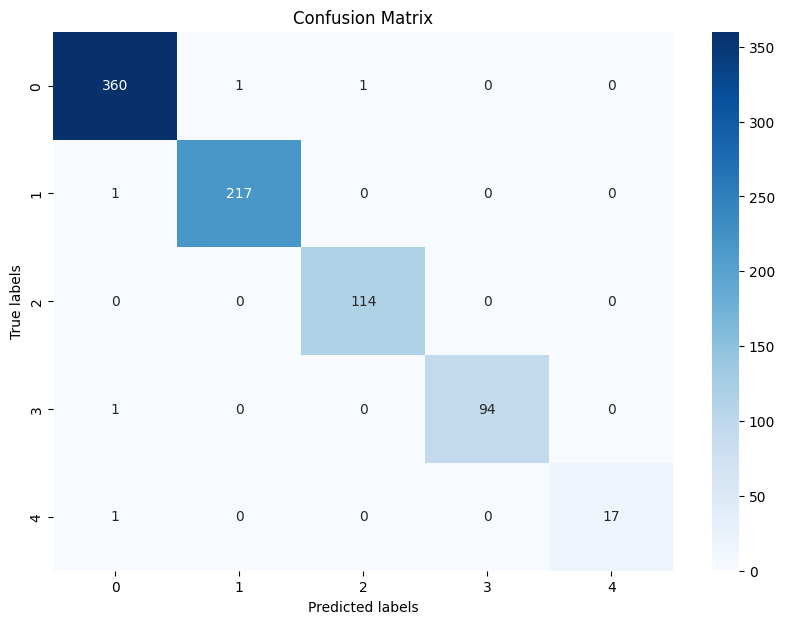

In [17]:
# load model and plot cmf
model_path = './hubert_depression_multiclass_model_cata'
model, optimizer = load_model(model_path, 2)
# val_loss, accuracy, precision, recall, f1 = evaluate(model, test_loader, criterion, device, writer, 6)
# print(f'Validation Loss: {val_loss:.4f}')
# print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)
            
            labels = labels.squeeze(1)
            
            labels = torch.argmax(labels, axis=1)
            outputs = model(input_values)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel('Predicted labels')
    plt.title('Confusion Matrix')
    plt.ylabel('True labels')
    plt.show()
    
    
plot_confusion_matrix(model, test_loader, device)

In [ ]:
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
# plt.xlabel('Predicted labels')
# plt.title('Confusion Matrix')
# plt.ylabel('True labels')
# plt.show()
# plot_confusion_matrix(model, test_loader, device)